In [1]:
%matplotlib inline

/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #515
  (fname, cnt))
/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #516
  (fname, cnt))


In [2]:
import numpy as np
import pandas as pd

#　統計用ツール
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from patsy import dmatrices

#　自作の空間統計用ツール
from spatialstat import *

#描画
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import seaborn as sns
sns.set(font=['IPAmincho'])

#深層学習
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

import pyper

In [3]:
data = pd.read_csv("TokyoSingle.csv")

In [4]:
data = data.dropna()

In [5]:
CITY_NAME = data['CITY_CODE'].copy()

In [6]:
CITY_NAME[CITY_NAME == 13101] = '01千代田区'
CITY_NAME[CITY_NAME == 13102] = "02中央区"
CITY_NAME[CITY_NAME == 13103] = "03港区"
CITY_NAME[CITY_NAME == 13104] = "04新宿区"
CITY_NAME[CITY_NAME == 13105] = "05文京区"
CITY_NAME[CITY_NAME == 13106] = "06台東区"
CITY_NAME[CITY_NAME == 13107] = "07墨田区"
CITY_NAME[CITY_NAME == 13108] = "08江東区"
CITY_NAME[CITY_NAME == 13109] = "09品川区"
CITY_NAME[CITY_NAME == 13110] = "10目黒区"
CITY_NAME[CITY_NAME == 13111] = "11大田区"
CITY_NAME[CITY_NAME == 13112] = "12世田谷区"
CITY_NAME[CITY_NAME == 13113] = "13渋谷区"
CITY_NAME[CITY_NAME == 13114] = "14中野区"
CITY_NAME[CITY_NAME == 13115] = "15杉並区"
CITY_NAME[CITY_NAME == 13116] = "16豊島区"
CITY_NAME[CITY_NAME == 13117] = "17北区"
CITY_NAME[CITY_NAME == 13118] = "18荒川区"
CITY_NAME[CITY_NAME == 13119] = "19板橋区"
CITY_NAME[CITY_NAME == 13120] = "20練馬区"
CITY_NAME[CITY_NAME == 13121] = "21足立区"
CITY_NAME[CITY_NAME == 13122] = "22葛飾区"
CITY_NAME[CITY_NAME == 13123] = "23江戸川区"

In [7]:
#Make Japanese Block name
BLOCK = data["CITY_CODE"].copy()
BLOCK[BLOCK == 13101] = "01都心・城南"
BLOCK[BLOCK == 13102] = "01都心・城南"
BLOCK[BLOCK == 13103] = "01都心・城南"
BLOCK[BLOCK == 13104] = "01都心・城南"
BLOCK[BLOCK == 13109] = "01都心・城南"
BLOCK[BLOCK == 13110] = "01都心・城南"
BLOCK[BLOCK == 13111] = "01都心・城南"
BLOCK[BLOCK == 13112] = "01都心・城南"
BLOCK[BLOCK == 13113] = "01都心・城南"
BLOCK[BLOCK == 13114] = "02城西・城北"
BLOCK[BLOCK == 13115] = "02城西・城北"
BLOCK[BLOCK == 13105] = "02城西・城北"
BLOCK[BLOCK == 13106] = "02城西・城北"
BLOCK[BLOCK == 13116] = "02城西・城北"
BLOCK[BLOCK == 13117] = "02城西・城北"
BLOCK[BLOCK == 13119] = "02城西・城北"
BLOCK[BLOCK == 13120] = "02城西・城北"
BLOCK[BLOCK == 13107] = "03城東"
BLOCK[BLOCK == 13108] = "03城東"
BLOCK[BLOCK == 13118] = "03城東"
BLOCK[BLOCK == 13121] = "03城東"
BLOCK[BLOCK == 13122] = "03城東"
BLOCK[BLOCK == 13123] = "03城東"

In [8]:
names = list(data.columns) + ['CITY_NAME', 'BLOCK']
data = pd.concat((data, CITY_NAME, BLOCK), axis = 1)
data.columns = names

### 変数名とデータの内容メモ
	CENSUS: 市区町村コード(9桁)
	P:      成約価格
	S:      専有面積
	L:      土地面積
	R:      部屋数
	RW:     前面道路幅員
	CY:     建築年
	A:      建築後年数(成約時)
	TS:     最寄駅までの距離
	TT:     東京駅までの時間
	ACC:    ターミナル駅までの時間
	WOOD:   木造ダミー
	SOUTH:  南向きダミー
	RSD:    住居系地域ダミー
	CMD:    商業系地域ダミー
	IDD:    工業系地域ダミー
	FAR:    建ぺい率
	FLR:    容積率
	TDQ:    成約時点(四半期)
	X:      緯度
	Y:      経度
	CITY_CODE: 市区町村コード(5桁)
	CITY_NAME: 市区町村名
	BLOCK:     地域ブロック名

In [9]:
s_data = data[['P', 'S', 'L', 'R', 'A', 'RW', 'TS', 'TT']]

In [10]:
s_data.describe()

,P,S,L,R,A,RW,TS,TT
count,77388.000000,77388.000000,77388.000000,77388.000000,77388.000000,77388.000000,77388.000000,77388.000000
mean,5745.409689,101.496476,86.631660,3.488978,50.046067,4.898872,10.339898,30.807698
std,3056.826263,35.732280,40.390705,0.918125,92.814379,1.997453,4.865877,7.738183
min,850.000000,31.190000,19.610000,0.000000,0.000000,2.000000,0.000000,1.000000
25%,3980.000000,84.250000,60.780000,3.000000,1.000000,4.000000,7.000000,26.000000
50%,4980.000000,94.600000,79.430000,3.000000,4.000000,4.000000,10.000000,31.000000
75%,6380.000000,106.510000,100.200000,4.000000,46.000000,5.500000,13.000000,37.000000
max,30000.000000,497.810000,495.860000,47.000000,412.000000,35.000000,69.000000,154.000000


#### 市区町村別の件数を集計

In [11]:
print(data['CITY_NAME'].value_counts())                       

12世田谷区    12340
20練馬区      9979
15杉並区      8131
11大田区      7052
21足立区      6479
19板橋区      4827
14中野区      3924
10目黒区      3418
22葛飾区      3165
23江戸川区     3156
09品川区      2424
16豊島区      2153
04新宿区      1885
17北区       1799
13渋谷区      1487
05文京区      1242
18荒川区      1005
08江東区       981
03港区        757
07墨田区       725
06台東区       371
02中央区        56
01千代田区       32
Name: CITY_NAME, dtype: int64


#### 成約時点別×市区町村別の件数を集計

In [12]:
print(data.pivot_table(index=['TDQ'], columns=['CITY_NAME'])) 

                 CENSUS                                            \
CITY_NAME        01千代田区         02中央区          03港区         04新宿区   
TDQ                                                                 
200001     1.310105e+10           NaN  1.310302e+10  1.310406e+10   
200002              NaN           NaN  1.310302e+10  1.310405e+10   
200003     1.310100e+10           NaN  1.310302e+10  1.310405e+10   
200004              NaN           NaN  1.310302e+10  1.310405e+10   
200101              NaN  1.310202e+10  1.310302e+10  1.310405e+10   
200102              NaN  1.310202e+10  1.310302e+10  1.310406e+10   
200103     1.310105e+10           NaN  1.310302e+10  1.310406e+10   
200104              NaN           NaN  1.310302e+10  1.310405e+10   
200201              NaN           NaN  1.310302e+10  1.310406e+10   
200202     1.310105e+10  1.310204e+10  1.310302e+10  1.310405e+10   
200203     1.310105e+10           NaN  1.310302e+10  1.310406e+10   
200204     1.310105e+10  1.310203e

#### 成約時点別×地域ブロック別の件数を集計

In [13]:
print(data.pivot_table(index=['TDQ'], columns=['BLOCK']))     

              CENSUS                                        P               \
BLOCK        01都心・城南       02城西・城北          03城東      01都心・城南      02城西・城北   
TDQ                                                                          
200001  1.311033e+10  1.311581e+10  1.312004e+10  7399.858911  5872.318681   
200002  1.311049e+10  1.311637e+10  1.312009e+10  7276.618938  5932.909408   
200003  1.311055e+10  1.311578e+10  1.312082e+10  7139.290816  6176.982456   
200004  1.311079e+10  1.311620e+10  1.312014e+10  7459.767967  5993.241259   
200101  1.311038e+10  1.311591e+10  1.312024e+10  7151.689342  5833.323113   
200102  1.311053e+10  1.311655e+10  1.312063e+10  7554.334135  5519.058796   
200103  1.311082e+10  1.311643e+10  1.312039e+10  7442.875670  5529.286207   
200104  1.311045e+10  1.311618e+10  1.312042e+10  7318.639191  5471.789796   
200201  1.311046e+10  1.311595e+10  1.312069e+10  6842.570213  5469.279188   
200202  1.311071e+10  1.311551e+10  1.312051e+10  6772.594912  5

## Histogram

#### 価格(真数)

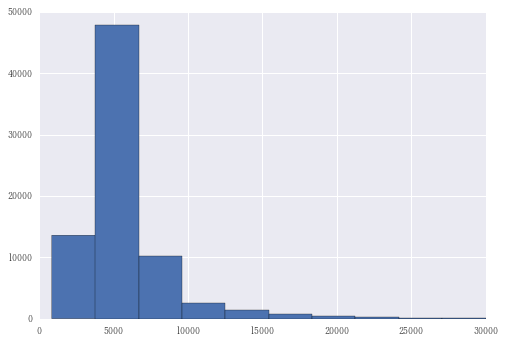

In [14]:
data['P'].hist()                       

#### 価格(自然対数)

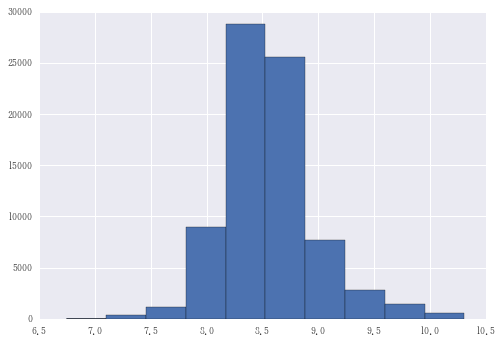

In [15]:
(np.log(data['P'])).hist()                

#### 建築後年数

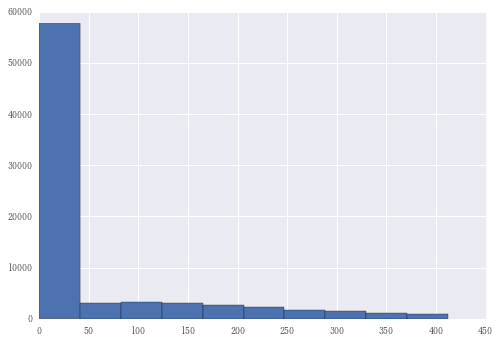

In [16]:
data['A'].hist()                       

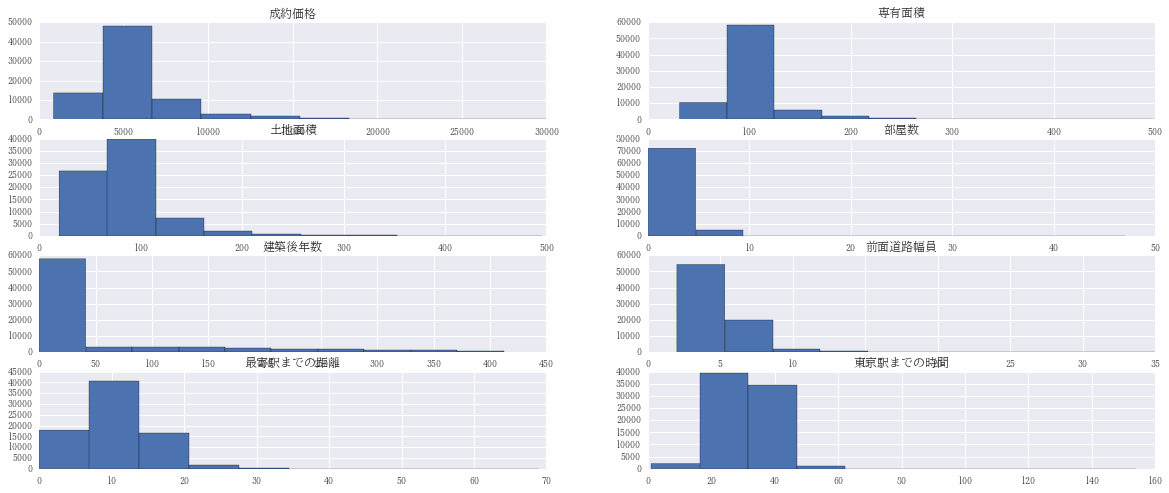

In [17]:
plt.figure(figsize=(20,8))

plt.subplot(4, 2, 1)
data['P'].hist()
plt.title(u"成約価格")

plt.subplot(4, 2, 2)
data['S'].hist()
plt.title("専有面積")

plt.subplot(4, 2, 3)
data['L'].hist()
plt.title("土地面積")

plt.subplot(4, 2, 4)
data['R'].hist()
plt.title("部屋数")

plt.subplot(4, 2, 5)
data['A'].hist()
plt.title("建築後年数")

plt.subplot(4, 2, 6)
data['RW'].hist()
plt.title("前面道路幅員")

plt.subplot(4, 2, 7)
data['TS'].hist()
plt.title("最寄駅までの距離")

plt.subplot(4, 2, 8)
data['TT'].hist()
plt.title(u"東京駅までの時間")

## Plot
#### 件数の推移

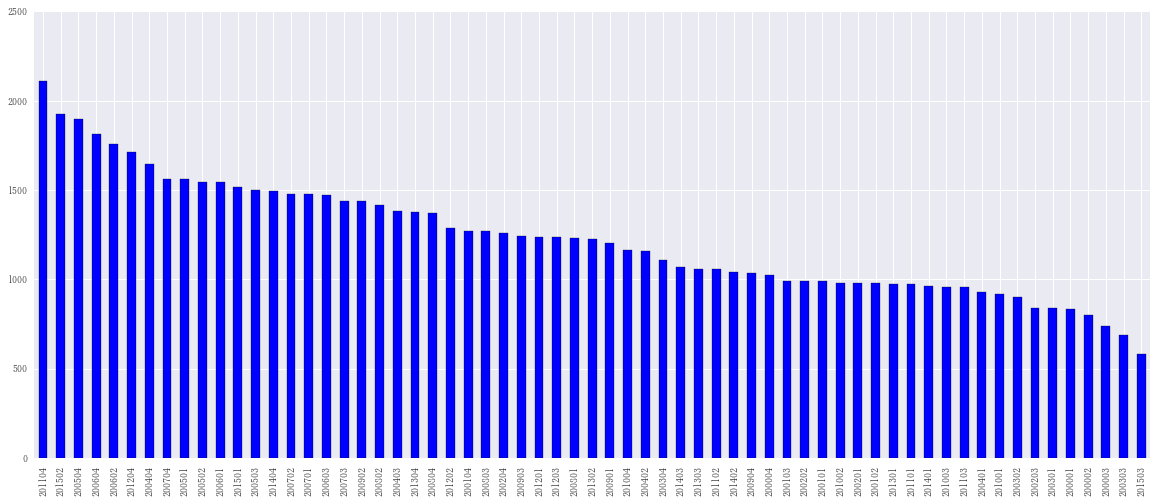

In [18]:
plt.figure(figsize=(20,8))
data['TDQ'].value_counts().plot(kind='bar') 

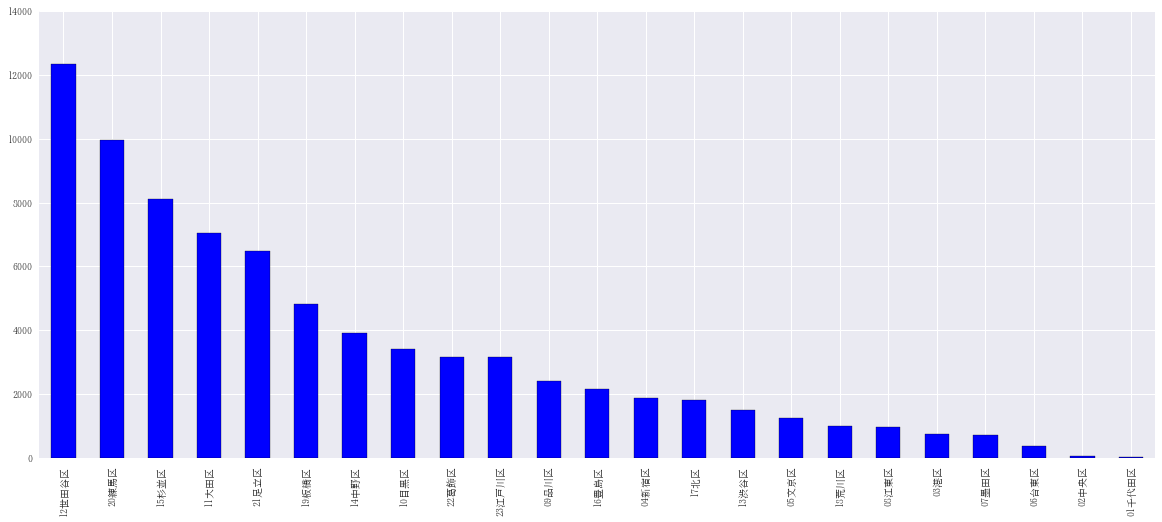

In [19]:
plt.figure(figsize=(20,8))
data['CITY_NAME'].value_counts().plot(kind='bar') #市区町村別の件数

### Main Analysis

#### OLS part

In [20]:
vars = ['P', 'S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR']
eq = fml_build(vars)

y, X = dmatrices(eq, data=data, return_type='dataframe')

CITY_NAME = pd.get_dummies(data['CITY_NAME'])
TDQ = pd.get_dummies(data['TDQ'])

X = pd.concat((X, CITY_NAME, TDQ), axis=1)

datas = pd.concat((y, X), axis=1)

datas = datas[datas['12世田谷区'] == 1][0:5000]

In [21]:
datas.head()

,P,Intercept,S,L,R,RW,A,TS,TT,WOOD,...,201302,201303,201304,201401,201402,201403,201404,201501,201502,201503
6,3960,1,61.96,80.01,3,2.8,174,4,27,1,...,0,0,0,0,0,0,0,0,0,0
7,6180,1,101.02,141.17,3,3.8,0,10,29,1,...,0,0,0,0,0,0,0,0,0,0
8,6380,1,100.40,147.71,4,4.0,171,10,38,1,...,0,0,0,0,0,0,0,0,0,0
9,6850,1,107.37,82.37,5,6.0,28,1,37,1,...,0,0,0,0,0,0,0,0,0,0
10,11880,1,160.28,105.80,4,6.0,0,10,37,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
vars = ['S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR']
#vars += vars + list(TDQ.columns)

In [23]:
class CAR(Chain):
    def __init__(self, unit1, unit2, unit3, col_num):
        self.unit1 = unit1
        self.unit2 = unit2
        self.unit3 = unit3
        super(CAR, self).__init__(
            l1 = L.Linear(col_num, unit1),
            l2 = L.Linear(self.unit1, self.unit1),
            l3 = L.Linear(self.unit1, self.unit2),
            l4 = L.Linear(self.unit2, self.unit3),
            l5 = L.Linear(self.unit3, self.unit3),
            l6 = L.Linear(self.unit3, 1),
        )
    
    def __call__(self, x, y):
        fv = self.fwd(x, y)
        loss = F.mean_squared_error(fv, y)
        return loss
    
    def fwd(self, x, y):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.sigmoid(self.l2(h1))
        h3 = F.sigmoid(self.l3(h2))
        h4 = F.sigmoid(self.l4(h3))
        h5 = F.sigmoid(self.l5(h4))
        h6 = self.l6(h5)
        return h6

In [43]:
class OLS_DLmodel(object):
    def __init__(self, data, vars, bs=200, n=1000):
        eq = fml_build(vars)
        y, X = dmatrices(eq, data=datas, return_type='dataframe')
        self.y_in = y[:-n]
        self.X_in = X[:-n]
        self.y_ex = y[-n:]
        self.X_ex = X[-n:]
        
        self.logy_in = np.log(self.y_in)
        self.logy_ex = np.log(self.y_ex)
        
        self.bs = bs

    def OLS(self):
        model = sm.OLS(self.logy_in, self.X_in, intercept=False)
        self.reg = model.fit()
        print(self.reg.summary())
        
    def directDL(self, ite=100, bs=200, add=False):
        logy_in = np.array(self.logy_in, dtype='float32')
        X_in = np.array(self.X_in, dtype='float32')

        y = Variable(logy_in)
        x = Variable(X_in)

        num, col_num = X_in.shape
        
        if add is False:
            self.model1 = CAR(10, 10, 3, col_num)
        
        optimizer = optimizers.SGD()
        optimizer.setup(self.model1)

        for j in range(ite):
            sffindx = np.random.permutation(num)
            for i in range(0, num, bs):
                x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                y = Variable(logy_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                self.model1.zerograds()
                loss = self.model1(x, y)
                loss.backward()
                optimizer.update()
            if j % 1000 == 0:
                loss_val = loss.data
                print('epoch:', j)
                print('train mean loss={}'.format(loss_val))
                print(' - - - - - - - - - ')
                
        y_ex = np.array(self.y_ex, dtype='float32').reshape(len(self.y_ex))
        X_ex = np.array(self.X_ex, dtype='float32')
        X_ex = Variable(X_ex)

        logy_pred =  self.model1.fwd(X_ex, X_ex).data
        y_pred = np.exp(logy_pred)
        error = y_ex - y_pred.reshape(len(y_pred),)
        plt.hist(error[:])
        
    def DL(self, ite=100, bs=200, add=False):
        y_in = np.array(self.y_in, dtype='float32').reshape(len(self.y_in))
                                                            
        resid = y_in - np.exp(self.reg.predict())
        resid = np.array(resid, dtype='float32').reshape(len(resid),1)
        
        X_in = np.array(self.X_in, dtype='float32')

        y = Variable(resid)
        x = Variable(X_in)

        num, col_num = X_in.shape
        
        if add is False:
            self.model1 = CAR(10, 10, 3, col_num)
            
        optimizer = optimizers.SGD()
        optimizer.setup(self.model1)

        for j in range(ite):
            sffindx = np.random.permutation(num)
            for i in range(0, num, bs):
                x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                y = Variable(resid[sffindx[i:(i+bs) if (i+bs) < num else num]])
                self.model1.zerograds()
                loss = self.model1(x, y)
                loss.backward()
                optimizer.update()
            if j % 1000 == 0:
                loss_val = loss.data
                print('epoch:', j)
                print('train mean loss={}'.format(loss_val))
                print(' - - - - - - - - - ')
            
    def predict(self):
        y_ex = np.array(self.y_ex, dtype='float32').reshape(len(self.y_ex))
        
        X_ex = np.array(self.X_ex, dtype='float32')
        X_ex = Variable(X_ex)
        resid_pred =  self.model1.fwd(X_ex, X_ex).data  
        print(resid_pred[:10])
        
        self.logy_pred = np.matrix(self.X_ex)*np.matrix(self.reg.params).T
        self.error1 = np.array(y_ex - np.exp(self.logy_pred.reshape(len(self.logy_pred),)))[0]
        
        self.pred = np.exp(self.logy_pred) + resid_pred
        self.error2 = np.array(y_ex - self.pred.reshape(len(self.pred),))[0]
        
    def compare(self):
        plt.hist(self.error1)
        plt.hist(self.error2)

In [44]:
vars = ['P', 'S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR']
#vars += vars + list(TDQ.columns)

In [45]:
model = OLS_DLmodel(datas, vars)

In [46]:
model.OLS()

                            OLS Regression Results                            
Dep. Variable:                      P   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1130.
Date:                Sat, 14 Jan 2017   Prob (F-statistic):               0.00
Time:                        21:21:30   Log-Likelihood:                 1308.3
No. Observations:                4000   AIC:                            -2591.
Df Residuals:                    3987   BIC:                            -2509.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.7986      0.038    228.864      0.0

In [47]:
model.DL(ite=10, bs=200)

epoch: 0
train mean loss=9139696.0
 - - - - - - - - - 


In [48]:
model.predict()

[[ 46.21097946]
 [ 46.21194839]
 [ 46.2109375 ]
 [ 46.21194839]
 [ 46.21100998]
 [ 46.21163559]
 [ 46.21095276]
 [ 46.21098328]
 [ 46.21194458]
 [ 46.21194839]]


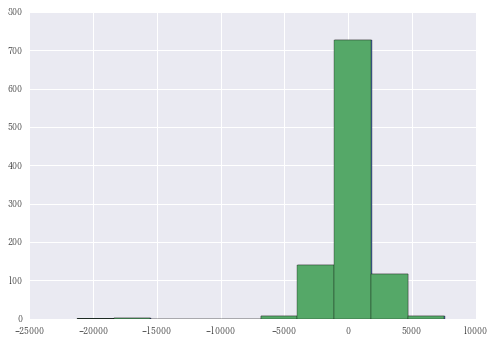

In [49]:
model.compare()

In [50]:
model.DL(ite=10, bs=200, add=True)

epoch: 0
train mean loss=2969150.75
 - - - - - - - - - 


In [51]:
model.predict()

[[ 54.80049515]
 [ 54.80391693]
 [ 54.80049133]
 [ 54.80049133]
 [ 54.80072784]
 [ 54.80351257]
 [ 54.80049133]
 [ 54.80049133]
 [ 54.80096436]
 [ 54.80392075]]


In [52]:
model.DL(1000, bs=200, add=True)

epoch: 0
train mean loss=7891431.5
 - - - - - - - - - 


In [53]:
model.predict()

[[ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]
 [ 55.82376862]]


In [54]:
model.DL(1000, bs=200, add=True)

epoch: 0
train mean loss=4348464.5
 - - - - - - - - - 


In [55]:
model.predict()

[[ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]
 [ 57.20746994]]


In [56]:
model.DL(2000, bs=200, add=True)

epoch: 0
train mean loss=2259737.0
 - - - - - - - - - 
epoch: 1000
train mean loss=1934597.75
 - - - - - - - - - 


In [57]:
model.predict()

[[ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]
 [ 59.5091095]]


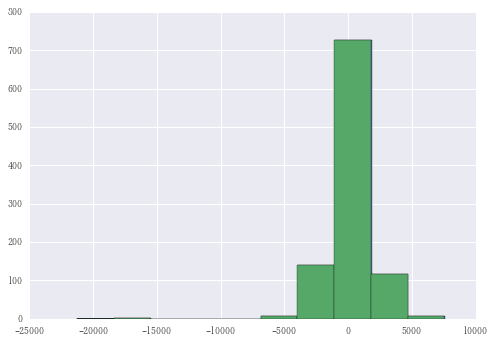

In [58]:
model.compare()

In [59]:
print(np.mean(model.error1))
print(np.mean(model.error2))

163.754931905
104.245822408


In [60]:
print(np.var(model.error1))
print(np.var(model.error2))

3690602.28497
3690602.28497


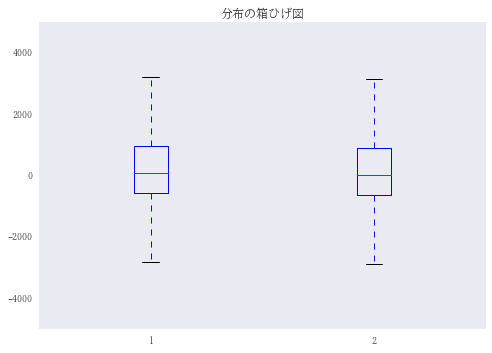

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)

errors = [model.error1, model.error2]

bp = ax.boxplot(errors)

plt.grid()
plt.ylim([-5000,5000])

plt.title('分布の箱ひげ図')

plt.show()

In [64]:
model.DL(5000, bs=200, add=True)

epoch: 0
train mean loss=4742665.0
 - - - - - - - - - 
epoch: 1000
train mean loss=3165670.75
 - - - - - - - - - 
epoch: 2000
train mean loss=4594728.5
 - - - - - - - - - 
epoch: 3000
train mean loss=9561405.0
 - - - - - - - - - 
epoch: 4000
train mean loss=2463281.0
 - - - - - - - - - 


In [65]:
model.predict()

[[ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]
 [ 59.68787384]]


In [74]:
model.DL(9000, bs=200, add=True)

epoch: 0
train mean loss=5081209.0
 - - - - - - - - - 
epoch: 1000
train mean loss=8229646.0
 - - - - - - - - - 
epoch: 2000
train mean loss=8551085.0
 - - - - - - - - - 
epoch: 3000
train mean loss=1784475.25
 - - - - - - - - - 
epoch: 4000
train mean loss=2248836.0
 - - - - - - - - - 
epoch: 5000
train mean loss=4779915.0
 - - - - - - - - - 
epoch: 6000
train mean loss=3850936.0
 - - - - - - - - - 
epoch: 7000
train mean loss=6645284.0
 - - - - - - - - - 
epoch: 8000
train mean loss=2687183.25
 - - - - - - - - - 


In [75]:
model.predict()

[[ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]
 [ 54.90478897]]


青がOLSの誤差、緑がOLSと深層学習を組み合わせた誤差。

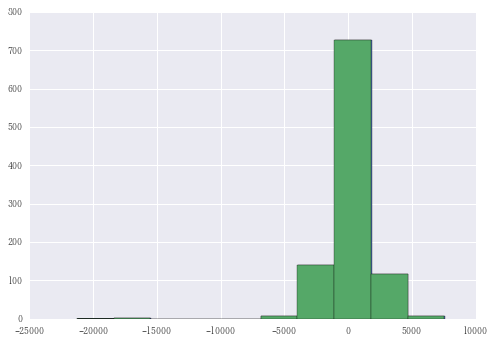

In [76]:
model.compare()

In [77]:
print(np.mean(model.error1))
print(np.mean(model.error2))

163.754931905
108.850142934


In [78]:
print(np.var(model.error1))
print(np.var(model.error2))

3690602.28497
3690602.28497


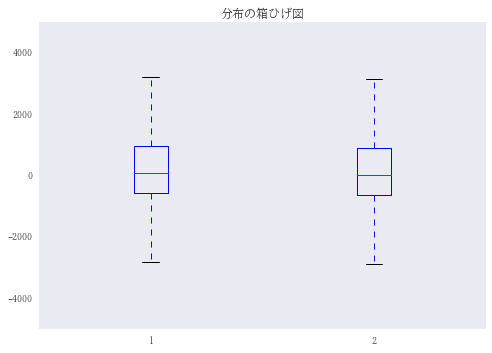

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)

errors = [model.error1, model.error2]

bp = ax.boxplot(errors)

plt.grid()
plt.ylim([-5000,5000])

plt.title('分布の箱ひげ図')

plt.show()

## MSE
OLS

In [80]:
sum(model.error1**2)/len(model.error1)

3717417.9626974021

OLS&DeepLearning

In [81]:
sum(model.error2**2)/len(model.error2)

3702450.638590998